In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta, tau0_from_mass1_mass2, tau3_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q, mass1_from_tau0_tau3, mass2_from_tau0_tau3, q_from_mass1_mass2, eta_from_q
import random
from pycbc.filter import sigmasq
from scipy.linalg import svd
from scipy.interpolate import CubicSpline, CubicHermiteSpline, interp1d, BarycentricInterpolator, krogh_interpolate, PchipInterpolator, Akima1DInterpolator
from scipy import special
from rbf.interpolate import RBFInterpolant
#from rbf.interpolate import _objective
from rbf.poly import mvmonos
from pycbc.detector import Detector
import h5py
import pickle
import matplotlib
from pycbc.types.timeseries import TimeSeries
from pycbc.types.array import complex_same_precision_as
from pycbc.conversions import mchirp_from_mass1_mass2
from pycbc.pnutils import get_final_freq
from pycbc.waveform import get_fd_waveform
from pycbc.filter.matchedfilter import get_cutoff_indices
from pycbc.fft import ifft
from pycbc.types import zeros
from pycbc.types.frequencyseries import load_frequencyseries
from pycbc.types.timeseries import load_timeseries
from tqdm import tqdm
from multiprocessing import Process
from multiprocessing.pool import Pool
from pycbc.inference.models.marginalized_gaussian_noise import MarginalizedPhaseGaussianNoise

from gwosc.datasets import event_gps
import time
import statistics
from functools import partial
from concurrent.futures import ProcessPoolExecutor
from pycbc import distributions
from scipy.stats import truncnorm
import copy
from gwfast.waveforms import TaylorF2_RestrictedPN, IMRPhenomD_NRTidalv2, IMRPhenomD
from gwfast.signal import GWSignal
from gwfast.network import DetNet
from fisherTools import CovMatr, compute_localization_region, check_covariance, fixParams
import gwfast.gwfastGlobals as glob
from scipy.stats import gaussian_kde
from fisherTools import dMc_dm1, dMc_dm2
from pycbc.filter.matchedfilter import matched_filter
from scipy.optimize import shgo, differential_evolution, minimize
from pycbc.conversions import mchirp_from_mass1_mass2

In [6]:
def negative_net_snr(params, data, psd):
    ifo = list(data.keys())
    m1, m2, s1, s2 = params
    hp, hc = get_fd_waveform(approximant = 'TaylorF2', mass1 = m1, mass2 = m2, spin1z = s1, spin2z = s2, delta_f = 1/data['L1'].duration, f_lower = 20, f_final = 1600)
    hp.resize(len(data['L1'])//2+1)
    net_snr = 0
    for i in range(len(ifo)):
        
        snr = matched_filter(hp, data[ifo[i]].to_frequencyseries(), psd[ifo[i]], low_frequency_cutoff = 20, high_frequency_cutoff= 1600)
        #snr = snr.crop(15,0)
        net_snr += np.max(np.array(abs(snr)**2))
        #print(np.max(np.array(abs(snr))))
    net_snr = np.sqrt(net_snr)
    #print('net_snr:', net_snr)
    
    return -net_snr

data = {'L1': load_timeseries('filter_data/filtered_L1_8_post_new_data.hdf'),\
         'V1': load_timeseries('filter_data/filtered_V1_8_post_new_data.hdf'),\
        'H1': load_timeseries('filter_data/filtered_H1_8_post_new_data.hdf')}

psd = {'L1': load_frequencyseries('PSD/PSD_L1.txt'),\
       'V1': load_frequencyseries('PSD/PSD_V1.txt'),\
       'H1': load_frequencyseries('PSD/PSD_H1.txt')}

def negative_net_snr_dummy(params):
    return negative_net_snr(params, data = data, psd = psd)

In [7]:
best_match = {'m1': 1.4574227, 'm2': 1.2993017, 's1': -0.018811436, 's2': 0.011776949}
best_match_params = [best_match['m1'], best_match['m2'], best_match['s1'], best_match['s2']]
st = time.time()
fid_params_minimize = minimize(negative_net_snr_dummy, best_match_params, bounds = [[best_match['m1'] - 0.1, best_match['m1'] + 0.1], [best_match['m2'] - 0.1, best_match['m2'] + 0.1], [best_match['s1'] - 0.1, best_match['s1'] + 0.1], [best_match['s2'] - 0.1, best_match['s2'] + 0.1]] , method = 'SLSQP')
et = time.time()
print(et - st)

65.28099131584167


In [8]:
fid_params_minimize

     fun: -33.90322247304244
     jac: array([-20.53843975, -23.15032625,   0.4867363 ,   0.42460775])
 message: 'Optimization terminated successfully'
    nfev: 121
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([ 1.45165672,  1.30389934, -0.11880696,  0.1093415 ])

In [9]:
hp, hc = get_fd_waveform(approximant = 'TaylorF2', mass1 = fid_params_minimize.x[0], mass2 = fid_params_minimize.x[1], spin1z = fid_params_minimize.x[2], spin2z = fid_params_minimize.x[3], delta_f = 1/data['L1'].duration, f_lower = 20, f_final = 1600)
hp.resize(len(data['L1'])//2+1)
snr = matched_filter(hp, data['L1'].to_frequencyseries(), psd['L1'], low_frequency_cutoff = 20, high_frequency_cutoff= 1600)


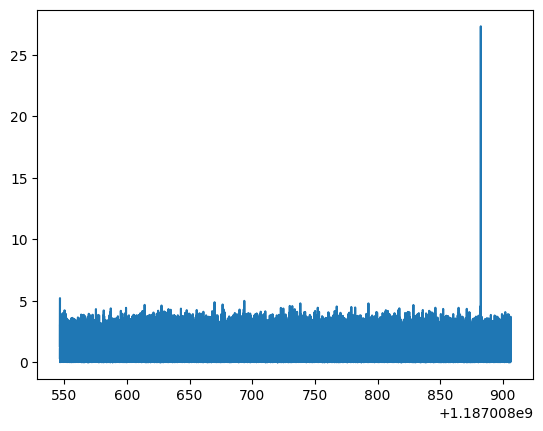

In [10]:
plt.plot(snr.sample_times, abs(snr))

1.1973550378719409
1.1133196252582054


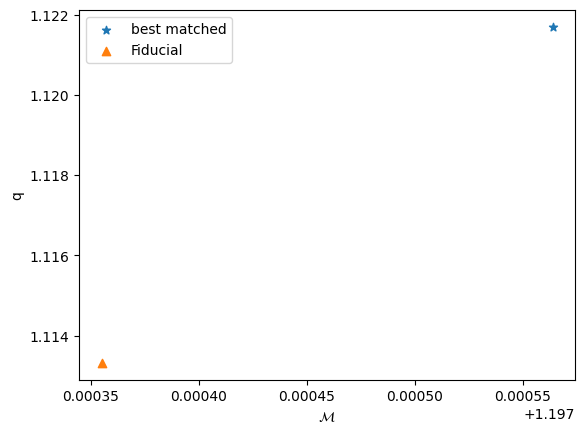

In [11]:
mchirp_best = mchirp_from_mass1_mass2(best_match_params[0], best_match_params[1])
mchirp_fid = mchirp_from_mass1_mass2(fid_params_minimize.x[0], fid_params_minimize.x[1])
print(mchirp_fid)
q_best = q_from_mass1_mass2(best_match_params[0], best_match_params[1])
q_fid = q_from_mass1_mass2(fid_params_minimize.x[0], fid_params_minimize.x[1])
print(q_fid)
plt.scatter(mchirp_best, q_best, marker = '*', label = 'best matched')
plt.scatter(mchirp_fid, q_fid, marker = '^', label = 'Fiducial')
plt.legend()
plt.xlabel(r'$\mathcal{M}$')
plt.ylabel('q')
plt.show()

In [12]:
def generate_nodes(boundary, mu, cov_mat, Nnodes, nodes_gauss_num, nodes_seed, size):
        
    """
    Function to generate nodes in the intrinsic parameter space
    
    Parameters
    -----------
    
    boundary: dictionary containing the intrinsic parameter boundaries (maxm and min values)
    fLow: seismic cutoff frequency
    Nnodes: no. of nodes
    
    Returns
    ---------
    
    nodes: uniformly sprayed points in intrinsic parameter space
    
    """
    
    # spraying random nodes in intrinsic parameter space
    
    mchirp_min, mchirp_max = boundary['mchirp']
    mass_ratio_min, mass_ratio_max = boundary['mass_ratio']
    s1z_min, s1z_max = boundary['s1z']
    s2z_min, s2z_max = boundary['s2z']
    
    np.random.seed(nodes_seed)
    temp = np.random.multivariate_normal(mu, cov_mat, size=size)
    
    
    idx = np.where((temp[:, 0] > mchirp_min) & (temp[:, 0] < mchirp_max) & (temp[:, 1] > mass_ratio_min) & (temp[:, 1] < mass_ratio_max) & (temp[:, 2] > s1z_min) & (temp[:, 2] < s1z_max) & (temp[:, 3] > s2z_min) & (temp[:, 3] < s2z_max))[0]
    
    
    gauss_nodes = temp[idx]
    
    
    gauss_nodes = gauss_nodes[:int(nodes_gauss_num*Nnodes), :]
    
#     while(True):
        
#         if(len(gauss_nodes) == int(nodes_gauss_num*Nnodes)):
            
#             break
        
#         temp = np.random.multivariate_normal(mu, cov_mat, size=1)[0]
#         m1 = mass1_from_mchirp_eta(temp[0], temp[1])
#         m2 = mass2_from_mchirp_eta(temp[0], temp[1])
#         if(~np.isnan(m1)):
#             mass_ratio = m1/m2

#             if(np.logical_and(temp[0] > mchirp_min, temp[0] < mchirp_max)):

#                 if(np.logical_and(mass_ratio > mass_ratio_min, mass_ratio <                                                       mass_ratio_max)):
                    
#                     if(np.logical_and(temp[2] > s1z_min, temp[2] < s1z_max)):
                        
#                         if(np.logical_and(temp[3] > s2z_min, temp[3] < s2z_max)):

                   
#                             gauss_nodes.append(np.array([temp[0], mass_ratio, temp[2], temp[3]]))


        

    mchirp_uni = (mchirp_max - mchirp_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mchirp_min
    mass_ratio_uni = (mass_ratio_max - mass_ratio_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mass_ratio_min
    s1z_uni = (s1z_max - s1z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s1z_min
    s2z_uni = (s2z_max - s2z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s2z_min
    
    if len(gauss_nodes) != 0:
        mchirp = np.append(gauss_nodes[:, 0], mchirp_uni)
        mass_ratio = np.append(gauss_nodes[:, 1], mass_ratio_uni)
        s1z = np.append(gauss_nodes[:, 2], s1z_uni)
        s2z = np.append(gauss_nodes[:, 3], s2z_uni)

        nodes = np.column_stack((mchirp, mass_ratio, s1z, s2z))
    
    if len(gauss_nodes) == 0:
        nodes = np.column_stack((mchirp_uni, mass_ratio_uni, s1z_uni, s2z_uni))
    
    return nodes

In [ ]:
def generate_nodes_normal(boundary, mu, cov_mat, Nnodes, nodes_gauss_num, nodes_seed):
        
    """
    Function to generate nodes in the intrinsic parameter space
    
    Parameters
    -----------
    
    boundary: dictionary containing the intrinsic parameter boundaries (maxm and min values)
    fLow: seismic cutoff frequency
    Nnodes: no. of nodes
    
    Returns
    ---------
    
    nodes: uniformly sprayed points in intrinsic parameter space
    
    """
    
    # spraying random nodes in intrinsic parameter space
    
    mchirp_min, mchirp_max = boundary['mchirp']
    mass_ratio_min, mass_ratio_max = boundary['mass_ratio']
    s1z_min, s1z_max = boundary['s1z']
    s2z_min, s2z_max = boundary['s2z']
    
    np.random.seed(nodes_seed)
    temp = np.random.multivariate_normal(mu, cov_mat, size=1000000)
    
    
    idx = np.where((temp[:, 0] > mchirp_min) & (temp[:, 0] < mchirp_max) & (temp[:, 1] > mass_ratio_min) & (temp[:, 1] < mass_ratio_max) & (temp[:, 2] > s1z_min) & (temp[:, 2] < s1z_max) & (temp[:, 3] > s2z_min) & (temp[:, 3] < s2z_max))[0]
    
    
    gauss_nodes = temp[idx]
    
    gauss_nodes = gauss_nodes[:int(nodes_gauss_num*Nnodes), :]

    mchirp_uni = (mchirp_max - mchirp_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mchirp_min
    mass_ratio_uni = (mass_ratio_max - mass_ratio_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mass_ratio_min
    s1z_uni = (s1z_max - s1z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s1z_min
    s2z_uni = (s2z_max - s2z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s2z_min
    
    if len(gauss_nodes) != 0:
        mchirp = np.append(gauss_nodes[:, 0], mchirp_uni)
        mass_ratio = np.append(gauss_nodes[:, 1], mass_ratio_uni)
        s1z = np.append(gauss_nodes[:, 2], s1z_uni)
        s2z = np.append(gauss_nodes[:, 3], s2z_uni)

        nodes = np.column_stack((mchirp, mass_ratio, s1z, s2z))
    
    if len(gauss_nodes) == 0:
        nodes = np.column_stack((mchirp_uni, mass_ratio_uni, s1z_uni, s2z_uni))
    
    return nodes

In [13]:
detectors_obj = copy.deepcopy(glob.detectors)
LVdetectors = {det:detectors_obj[det] for det in ['L1', 'H1', 'Virgo']}

In [14]:
LVdetectors['L1']['psd_path'] = 'PSD/PSD_L1.txt'
LVdetectors['H1']['psd_path'] = 'PSD/PSD_H1.txt'
LVdetectors['Virgo']['psd_path'] = 'PSD/PSD_V1.txt'

In [15]:
myLVSignals_Taylor = {}

for d in LVdetectors.keys():

    myLVSignals_Taylor[d] = GWSignal(TaylorF2_RestrictedPN(), 
                psd_path=LVdetectors[d]['psd_path'],
                detector_shape = LVdetectors[d]['shape'],
                det_lat= LVdetectors[d]['lat'],
                det_long=LVdetectors[d]['long'],
                det_xax=LVdetectors[d]['xax'], 
                verbose=True,
                is_ASD = False,
                useEarthMotion = True,
                fmin=20., fmax = 1600,
                IntTablePath=None) 

myLVNet_Taylor = DetNet(myLVSignals_Taylor) 

GW170817 = {'m1': np.array([fid_params_minimize.x[0]]), 'm2': np.array([fid_params_minimize.x[1]]), \
'chi1z': np.array([fid_params_minimize.x[2]]), 'chi2z': np.array([fid_params_minimize.x[3]]),\
            'tGPS': np.array([1187008882.4]),\
            'iota':np.array([2.54]),\
            'ra': np.array([3.42]),\
            'dec': np.array([-0.361]),\
            'dL': np.array([39.4/1000]),\
            'psi': np.array([0.]),\
            'Phicoal':np.array([0.])}



Using PSD from file PSD/PSD_L1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using PSD from file PSD/PSD_H1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using PSD from file PSD/PSD_V1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8


In [16]:
myLVSignals_IMR = {}

for d in LVdetectors.keys():

    myLVSignals_IMR[d] = GWSignal(IMRPhenomD(), 
                psd_path=LVdetectors[d]['psd_path'],
                detector_shape = LVdetectors[d]['shape'],
                det_lat= LVdetectors[d]['lat'],
                det_long=LVdetectors[d]['long'],
                det_xax=LVdetectors[d]['xax'], 
                verbose=True,
                is_ASD = False,
                useEarthMotion = True,
                fmin=20., fmax = 1600,
                IntTablePath=None) 

myLVNet_IMR = DetNet(myLVSignals_IMR) 





Using PSD from file PSD/PSD_L1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using PSD from file PSD/PSD_H1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using PSD from file PSD/PSD_V1.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8


In [17]:
kwargs = {'df': 1./360, 'spacing': 'geom', 'use_m1m2': True}
fisher_11d_Taylor = myLVNet_Taylor.FisherMatr(GW170817, **kwargs)
print('The computed Fisher matrix has shape %s'%str(fisher_11d_Taylor.shape))

Adding tcoal from tGPS
Adding Mc and eta from the individual detector-frame masses
Adding (theta, phi) from (ra, dec)
Computing Fisher for L1...
Computing derivatives...
Computing Fisher for H1...
Computing derivatives...
Computing Fisher for Virgo...
Computing derivatives...
Done.
The computed Fisher matrix has shape (11, 11, 1)


In [18]:
#kwargs = {'df': 1./360, 'spacing': 'geom', 'use_m1m2': True}
fisher_11d_IMR = myLVNet_IMR.FisherMatr(GW170817, **kwargs)
print('The computed Fisher matrix has shape %s'%str(fisher_11d_IMR.shape))

Computing Fisher for L1...
Computing derivatives...
Computing Fisher for H1...
Computing derivatives...
Computing Fisher for Virgo...
Computing derivatives...
Done.
The computed Fisher matrix has shape (11, 11, 1)


In [19]:
parNums = {'m1': 0, 'm2': 1, 'dL': 2, 'theta': 3, 'phi': 4, 'iota': 5, 'psi': 6, 'tcoal': 7, 'Phicoal': 8, 'chi1z': 9, 'chi2z': 10}
print(IMRPhenomD().ParNums)
fisher_4d_Taylor, params_Taylor = fixParams(fisher_11d_Taylor, parNums, ['iota', 'theta', 'phi', 'dL', 'psi', 'Phicoal', 'tcoal'])
covMat_4d_Taylor = CovMatr(fisher_4d_Taylor)[0].reshape(4, 4)

print('Covariance matrix from gwfast: \n', covMat_4d_Taylor)
print(fisher_4d_Taylor)
print(params_Taylor)


{'Mc': 0, 'eta': 1, 'dL': 2, 'theta': 3, 'phi': 4, 'iota': 5, 'psi': 6, 'tcoal': 7, 'Phicoal': 8, 'chi1z': 9, 'chi2z': 10}
Covariance matrix from gwfast: 
 [[ 0.01740674 -0.01531211  0.11536515 -0.12698189]
 [-0.01531211  0.01346953 -0.10149697  0.11171789]
 [ 0.11536515 -0.10149697  1.06251736 -1.18260066]
 [-0.12698189  0.11171789 -1.18260066  1.31666976]]
[[[ 2.36977242e+09]
  [ 2.63997199e+09]
  [-1.89754361e+08]
  [-1.65886347e+08]]

 [[ 2.63997199e+09]
  [ 2.94149277e+09]
  [-2.09617137e+08]
  [-1.83251782e+08]]

 [[-1.89754361e+08]
  [-2.09617137e+08]
  [ 2.13208741e+07]
  [ 1.86354211e+07]]

 [[-1.65886347e+08]
  [-1.83251782e+08]
  [ 1.86354211e+07]
  [ 1.62882162e+07]]]
{'m1': 0, 'm2': 1, 'chi1z': 2, 'chi2z': 3}


In [20]:
parNums = {'m1': 0, 'm2': 1, 'dL': 2, 'theta': 3, 'phi': 4, 'iota': 5, 'psi': 6, 'tcoal': 7, 'Phicoal': 8, 'chi1z': 9, 'chi2z': 10}

fisher_4d_IMR, params_IMR = fixParams(fisher_11d_IMR, parNums, ['iota', 'theta', 'phi', 'dL', 'psi', 'Phicoal', 'tcoal'])
covMat_4d_IMR = CovMatr(fisher_4d_IMR)[0].reshape(4, 4)

print('Covariance matrix from gwfast: \n', covMat_4d_IMR)
print(fisher_4d_IMR)
print(params_IMR)


Covariance matrix from gwfast: 
 [[  1.42688679  -1.25398406   3.81460398  -3.90938647]
 [ -1.25398406   1.10203279  -3.35239974   3.43570144]
 [  3.81460398  -3.35239974  10.49631306 -10.79404437]
 [ -3.90938647   3.43570144 -10.79404437  11.10466409]]
[[[ 3.80323899e+10]
  [ 4.30434900e+10]
  [-7.46163745e+08]
  [-6.53364650e+08]]

 [[ 4.30434900e+10]
  [ 4.87148805e+10]
  [-8.44373740e+08]
  [-7.39360966e+08]]

 [[-7.46163745e+08]
  [-8.44373740e+08]
  [ 1.49551658e+07]
  [ 1.30936290e+07]]

 [[-6.53364650e+08]
  [-7.39360966e+08]
  [ 1.30936290e+07]
  [ 1.14638164e+07]]]
{'m1': 0, 'm2': 1, 'chi1z': 2, 'chi2z': 3}


In [21]:
def dq_dm1(m2):
    return (1/m2)

def dq_dm2(m1, m2):
    return -(m1/m2**2)



def Jacobian_mat(m1, m2):
    # Transforms m1, m2, chi1z, chi2z to Mc, q, chi1z, chi2z
    dMc_dm1_jacob = dMc_dm1(m1, m2)
    dMc_dm2_jacob = dMc_dm2(m1, m2)
    # dMc_dchi1_jacob = ((m1**3)/(-2*s1))*dMc_dm1(m1, m2)
    # dMc_dchi2_jacob = ((m2**3)/(-2*s2))*dMc_dm2(m1, m2)
    dMc_dchi1_jacob = 0
    dMc_dchi2_jacob = 0
    
    dq_dm1_jacob = dq_dm1(m2)
    dq_dm2_jacob = dq_dm2(m1, m2)
    # dq_dchi1_jacob = ((m1**3)/(-2*s1))*dq_dm1(m2)
    # dq_dchi2_jacob = ((m2**3)/(-2*s2))*dq_dm2(m1, m2)
    dq_dchi1_jacob = 0
    dq_dchi2_jacob = 0
    
    dchi1_dm1_jacob = 0
    #dchi1_dm1_jacob = (-2*s1)/m1**3
    dchi1_dm2_jacob = 0
    dchi1_dchi1_jacob = 1
    dchi1_dchi2_jacob = 0
    
    dchi2_dm1_jacob = 0
    #dchi2_dm2_jacob = (-2*s2)/m2**3
    dchi2_dm2_jacob = 0
    dchi2_dchi1_jacob = 0
    dchi2_dchi2_jacob = 1
    
    jacob = np.array([[dMc_dm1_jacob, dMc_dm2_jacob, dMc_dchi1_jacob, dMc_dchi2_jacob], [dq_dm1_jacob, dq_dm2_jacob, dq_dchi1_jacob, dq_dchi2_jacob], [dchi1_dm1_jacob, dchi1_dm2_jacob, dchi1_dchi1_jacob, dchi1_dchi2_jacob], [dchi2_dm1_jacob, dchi2_dm2_jacob, dchi2_dchi1_jacob, dchi2_dchi2_jacob]])
    
    return jacob

jacob_mat = Jacobian_mat(GW170817['m1'][0], GW170817['m2'][0])
print(jacob_mat.shape)
print(jacob_mat)
covMat_4d_q_Taylor = np.array(jacob_mat@covMat_4d_Taylor@jacob_mat.T, dtype = np.float32)
print(covMat_4d_q_Taylor)
    

(4, 4)
[[ 0.40798703  0.46406798  0.          0.        ]
 [ 0.76693037 -0.85383863  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 1.3733026e-09 -6.2767908e-06 -3.4008495e-05  3.7729307e-05]
 [-6.2767908e-06  4.0111970e-02  1.7513907e-01 -1.9277531e-01]
 [-3.4008495e-05  1.7513907e-01  1.0625174e+00 -1.1826006e+00]
 [ 3.7729307e-05 -1.9277531e-01 -1.1826006e+00  1.3166698e+00]]


In [22]:
covMat_4d_q_IMR = np.array(jacob_mat@covMat_4d_IMR@jacob_mat.T, dtype = np.float32)
print(covMat_4d_q_IMR)

[[ 3.39806689e-08  3.29931208e-04  5.67556941e-04 -5.79927699e-04]
 [ 3.29931208e-04  3.28500056e+00  5.78794384e+00 -5.93176174e+00]
 [ 5.67556941e-04  5.78794384e+00  1.04963131e+01 -1.07940445e+01]
 [-5.79927699e-04 -5.93176174e+00 -1.07940445e+01  1.11046638e+01]]


In [23]:
def hnormsq_dh_overlap(node, approximant, f_low, f_high, data, tc, psd):
    
    mchirp, mass_ratio, s1, s2 = node
    
    m1 = mass1_from_mchirp_q(mchirp, mass_ratio)
    m2 = mass2_from_mchirp_q(mchirp, mass_ratio)
    
    theta0 = 2*np.pi*f_low*tau0_from_mass1_mass2(m1, m2, f_low)
    theta3 = 2*np.pi*f_low*tau3_from_mass1_mass2(m1, m2, f_low)
    node_theta_space = [theta0, theta3, s1, s2]
    
    time_slice_z_len = len(data.time_slice(tc - 0.15, tc + 0.15))
    
    hp, _ = get_fd_waveform(approximant=approximant, mass1=m1, mass2=m2, spin1z=s1, spin2z=s2, delta_f=1/data.duration, f_lower=f_low, f_final = f_high)

    
    d = data.copy()
    stilde = d.to_frequencyseries()

    N = (len(stilde)-1) * 2
    kmin, kmax = get_cutoff_indices(f_low, f_high, stilde.delta_f, N)

    kmax = min(len(hp), kmax)

    qtilde = zeros(N, dtype=complex_same_precision_as(d))
    _q = zeros(N, dtype=complex_same_precision_as(d))

    qtilde[kmin:kmax] = hp[kmin:kmax].conj()*stilde[kmin:kmax]

    
    p = psd.copy()
    qtilde[kmin:kmax] /= p[kmin:kmax]

    ifft(qtilde, _q) 
    z = 4.0*stilde.delta_f*_q
    z = TimeSeries(z, delta_t = d.delta_t, epoch = d.start_time, dtype = complex_same_precision_as(d))
    
    z = z.time_slice(tc - 0.15, tc + 0.15)
    
    hnormsq = sigmasq(hp, p, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high).real   
    return hnormsq, z, node_theta_space


def RBFinterpolants(ifo, data, approximant, nodes, f_low, f_high, tc, psd, nbasis, nprocs):
    
    global hnormsq_z_cal_parallel
    
    # data ----> filtered data output from detector
    # Nnodes ----> number of points in parameter space to be used for start-up stage
    # f_low -----> low cutoff frequency
    # f_high ----> high cutoff frequency
    # ifo ----> list of interferometers
    # nbasis ----->  no. of retained top basis vectors for which interpolants are calculated 
    # tc -------> Time of coalescence
    # order ----> order of monomial terms
    # phi -------> Type of RBF
    # eps -------> Shape Parameter
    # fixed_params ------> extrinsic parameters dictionary; fixed_params = {'ra': .., 'dec': .., 'distance': .., 'iota': .., 'polarization': ..}
    
#     if (Nnodes < nbasis):
#         raise Exception('No. of nodes must be larger than number of retained basis')
    
    
    # Calculating SNR and <h0|h0> for brute force calculations
    # z_real_dict = {}
    # mod_z = {}
    # z_img_dict = {}
    # hnormsq_dict = {}
    # C_real = {}
    # C_img = {}
    # basis_img_vectors = {}
    # basis_real_vectors = {}
    # C_real_interpolant = {}
    # C_img_interpolant = {}
    # hp_hp_interpolant = {}
    times = data.time_slice(tc - 0.15, tc + 0.15).sample_times.data
    #params = nodes_gen(params_range, Nnodes, 0)
    #nodes = nodes_gen(params_range, Nnodes, seed = 0)
    
    def hnormsq_z_cal_parallel(node):
        return hnormsq_dh_overlap(node, approximant = approximant, f_low = f_low, f_high = f_high, data = data, tc = tc, psd = psd)
    #print(nodes)
    # for i in range(len(ifo)):
    
    
    with Pool(nprocs) as exe:
        result = tqdm(exe.map(hnormsq_z_cal_parallel, nodes), total = len(nodes))

    z_mat = np.zeros((len(nodes), len(times)), dtype = complex)

    hnormsq_mat = np.zeros((1, len(nodes)))
    nodes_theta = np.zeros((len(nodes), 4))


    for index, i in enumerate(result):
        hnormsq_mat[0, index] = i[0]
        z_mat[index] = i[1]
        nodes_theta[index] = i[2]

    # hnormsq, z_real, z_img, nodes, mod_z, params = hnormsq_z_calc(approximant, 0, params_range, Nnodes, f_low, f_high, data, tc, psd)
    
    u, s, vh = svd(z_mat, full_matrices=False)
    
    sigma = np.diag(s)
    
    C = np.matmul(u, sigma)
    
    basis_vectors = vh[0:nbasis, :]
    
#         for j in range(nodes):
#             z_dict[ifo[i]][j, :] = z_dict[ifo[i]][j, :].time_slice(tc - 0.15, tc + 0.15)
    # hp_hp_interpolant, C_real_interpolant, C_img_interpolant = createRBFInterpolants(nodes, hnormsq[0], C_real, C_img, nbasis, phi, order, eps)
        #print(basis_vectors[ifo[i]].shape)
    return ifo, basis_vectors, times, C, nodes_theta, hnormsq_mat, z_mat, s

def createRBFInterpolants(nodes, h0_h0, C_interp, nBasis, phi, order, eps):
  
    """This function creates rbf interpolants for svd coefficients (C) and template norm square (h0_h0) ---
  
    Parameters
    -----------
    nodes: list of nodes 
    
    h0_h0: values of h0_h0 at nodes
    
    C: svd coefficients
    
    nBasis: no. of retained top basis vectors for which the interpolants (C) are generated
    
    phi: rbf kernel
    
    order: order of the monomial terms
  
    Returns
    --------
    h0_h0_interpolant (python object)
    
    C_interpolant (python object)
  
    For more details regarding rbf interpolation package, please visit https://rbf.readthedocs.io/en/latest/interpolate.html"""
  
    # h0_h0 interpolant
    h0_h0_interpolant = RBFInterpolant(nodes, h0_h0, phi=phi, order=order, eps= eps)
    #print('h_h Interpolant generated....')
    
    # svd coefficients interpolant
    C_interpolant = []
    

    for i in tqdm(range(nBasis)):
        
        C_interpolant.append(RBFInterpolant(nodes, C_interp[:,i], phi=phi, order=order, eps= eps))
        
        #print('C Interpolant for %d basis generated....'%(i+1))
    
    C_interpolant = np.array(C_interpolant)# svd coefficients interpolants
    
    
    return h0_h0_interpolant, C_interpolant


def RBF_parallel(ifo, data, approximant, nodes, f_low, f_high, tc, psd, nbasis, phi, order, eps, nprocs):
    global RBF_interpolants_parallel
    def RBF_interpolants_parallel(ifo):
        return RBFinterpolants(ifo, data = data[ifo], approximant = approximant, nodes = nodes, f_low = f_low, f_high = f_high, tc = tc, psd = psd[ifo], nbasis = nbasis, nprocs = nprocs)
    
    with ProcessPoolExecutor(max_workers = 1) as exe:
        result = exe.map(RBF_interpolants_parallel, ifo)

    basis_vectors = {}

    C = {}

    z = {}

    nodes_theta = {}
    hnormsq = {}
    hp_hp_interpolant = {}
    C_interpolant = {}

    s = {}


    for i in result:
        ifos = i[0]
        basis_vectors[ifos] = i[1]

        times = i[2] 

        C[ifos] = i[3]


        nodes_theta[ifos] = i[4]
        hnormsq[ifos] = i[5]
        z[ifos] = i[6]

        s[ifos] = i[7]

    for j in ifo:
        hp_hp_interpolant[j], C_interpolant[j] = createRBFInterpolants(nodes_theta[j], hnormsq[j][0], C[j], nbasis, phi, order, eps)
    return hp_hp_interpolant, C_interpolant, basis_vectors, times

In [116]:
import time
tc = 1187008882.4
boundary = {'mchirp': np.array([mchirp_fid - 0.0001, mchirp_fid + 0.0001]), 'mass_ratio': np.array([q_fid - 0.1, q_fid + 0.1]),\
            's1z': np.array([fid_params_minimize.x[2] - 0.01, fid_params_minimize.x[2] + 0.01]), 's2z': np.array([fid_params_minimize.x[3] - 0.01, fid_params_minimize.x[3] + 0.01]),\
            'distance': [10, 60], 'ra': [0, 2*np.pi], 'dec':[-np.pi/2, np.pi/2],\
            'inc':[0, np.pi], 'tc':[tc - 0.12, tc + 0.12], 'pol': [0, 0]}
center = [mchirp_fid, q_fid, fid_params_minimize.x[2], fid_params_minimize.x[3]]
nodes_seed = 0
nodes_gauss_num = 0.2
Nnodes = 800
size = 10000000
st = time.time()
nodes_Taylor = generate_nodes(boundary, center, covMat_4d_q_Taylor, Nnodes, nodes_gauss_num, nodes_seed, size)
et = time.time()
print(et - st)


# st_IMR = time.time()
# nodes_IMR = generate_nodes(boundary, center, covMat_4d_q_IMR, Nnodes, nodes_gauss_num, nodes_seed, size)
# et_IMR = time.time()
# print(et_IMR - st_IMR)
# print(len(nodes_IMR))

1.195760726928711


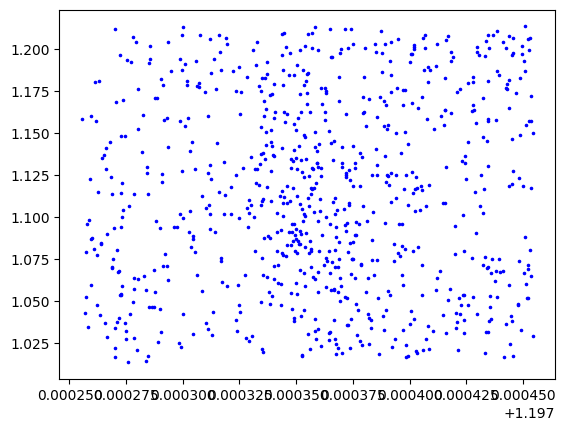

In [117]:
#plt.scatter(nodes_normal[:, 0], nodes_normal[:, 1], 15, marker = '.', label = 'normal nodes')
#plt.scatter(nodes_IMR[:, 0], nodes_IMR[:, 1], 10, marker = '.', label = 'nodes_IMRPhenomD')
plt.scatter(nodes_Taylor[:, 0], nodes_Taylor[:, 1], 10, marker = '.', c = 'blue')
#plt.scatter(nodes_IMR[:, 0], nodes_IMR[:, 1], 10, marker = '.', label = 'nodes_IMRPhenomD', c = 'red')
#plt.legend()
plt.show()

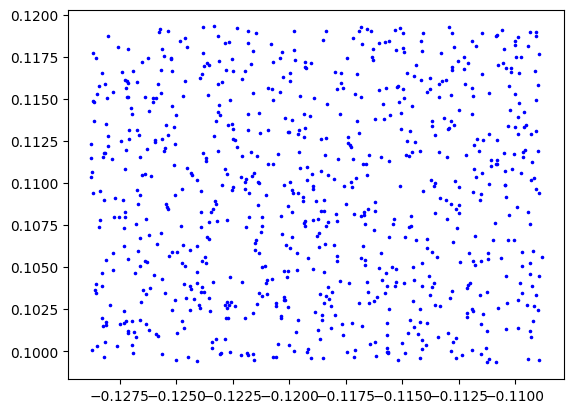

In [118]:
plt.scatter(nodes_Taylor[:, 2], nodes_Taylor[:, 3], 10, marker = '.', label = 'nodes_TaylorF2', c = 'blue')
#plt.scatter(nodes_IMR[:, 2], nodes_IMR[:, 3], 10, marker = '.', label = 'nodes_IMRPhenomD', c = 'red')
#plt.legend()
plt.show()

In [119]:
ifos = ['L1', 'H1', 'V1']
data = {'L1': load_timeseries('filter_data/filtered_L1_8_post_new_data.hdf'),\
         'V1': load_timeseries('filter_data/filtered_V1_8_post_new_data.hdf'),\
        'H1': load_timeseries('filter_data/filtered_H1_8_post_new_data.hdf')}

psd = {'L1': load_frequencyseries('PSD/PSD_L1.txt'),\
       'V1': load_frequencyseries('PSD/PSD_V1.txt'),\
       'H1': load_frequencyseries('PSD/PSD_H1.txt')}
#hp_hp_interpolant_IMR, C_interpolant_IMR, basis_vectors_IMR, times_IMR = RBF_parallel(ifos, data, 'IMRPhenomD', nodes_IMR, 20, 1600, tc, psd, 20, 'ga', 8, 10, 32)
hp_hp_interpolant_Taylor, C_interpolant_Taylor, basis_vectors_Taylor, times_Taylor = RBF_parallel(ifos, data, 'TaylorF2', nodes_Taylor, 20, 1600, tc, psd, 20, 'ga', 7, 10, 32)


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


In [120]:
approximant_taylor = 'TaylorF2'
approximant_IMR = 'IMRPhenomD'
f_low = 20
f_high = 1600

static_params_taylor = {'approximant': approximant_taylor, 'f_lower': f_low}
static_params_IMR = {'approximant': approximant_IMR, 'f_lower': f_low}

variable_params = ['mass1', 'mass2', 'spin1z', 'spin2z', 'distance', 'tc', 'ra', 'dec', 'inclination', 'polarization']

# low_frequency_cutoff_L1 = {'L1': f_low}
# low_frequency_cutoff_V1 = {'V1': f_low}
low_frequency_cutoff = {'L1': f_low, 'V1': f_low, 'H1': f_low}
high_frequency_cutoff = {'L1': f_high, 'V1': f_high, 'H1': f_high}

data_frequency = {'L1': load_timeseries('filter_data/filtered_L1_8_post_new_data.hdf').to_frequencyseries(),\
                     'V1': load_timeseries('filter_data/filtered_V1_8_post_new_data.hdf').to_frequencyseries(),\
                    'H1': load_timeseries('filter_data/filtered_H1_8_post_new_data.hdf').to_frequencyseries()}



psd = {'L1': load_frequencyseries('PSD/PSD_L1.txt'),\
               'V1': load_frequencyseries('PSD/PSD_V1.txt'),\
               'H1': load_frequencyseries('PSD/PSD_H1.txt')}


model_Taylor = MarginalizedPhaseGaussianNoise(variable_params,\
                                              data_frequency,\
                                              low_frequency_cutoff = low_frequency_cutoff,\
                                              psds = psd, high_frequency_cutoff = high_frequency_cutoff, static_params= static_params_taylor)

model_IMR = MarginalizedPhaseGaussianNoise(variable_params,\
                                              data_frequency,\
                                              low_frequency_cutoff = low_frequency_cutoff,\
                                              psds = psd, high_frequency_cutoff = high_frequency_cutoff, static_params= static_params_IMR)


def pycbc_log_likelihood_taylor(q):
        
    """
    Function to calculate pycbc log-likelihood
    
    Parameters
    -----------
    q: parameters
    model: pycbc object containg the information regarding noise and waveform model
    PSD: power spectral density
    data: strain data
    
    Returns
    --------
    model.loglr: marginalized phase likelihood
    
    For more details visit: https://pycbc.org/pycbc/latest/html/_modules/pycbc/inference/models/
    marginalized_gaussian_noise.html#MarginalizedPhaseGaussianNoise
        
    """
    mchirp, q, s1z, s2z, distance, tc, ra, dec, inc, pol = q
    m1 = mass1_from_mchirp_q(mchirp, q)
    m2 = mass2_from_mchirp_q(mchirp, q)

    model_Taylor.update(mass1=m1, mass2=m2, spin1z=s1z, spin2z=s2z, distance = distance, tc =tc, ra =ra, dec = dec, inclination = inc, polarization = pol)

    return model_Taylor.loglr



def pycbc_log_likelihood_IMR(q):
        
    """
    Function to calculate pycbc log-likelihood
    
    Parameters
    -----------
    q: parameters
    model: pycbc object containg the information regarding noise and waveform model
    PSD: power spectral density
    data: strain data
    
    Returns
    --------
    model.loglr: marginalized phase likelihood
    
    For more details visit: https://pycbc.org/pycbc/latest/html/_modules/pycbc/inference/models/
    marginalized_gaussian_noise.html#MarginalizedPhaseGaussianNoise
        
    """
    mchirp, q, s1z, s2z, distance, tc, ra, dec, inc, pol = q
    m1 = mass1_from_mchirp_q(mchirp, q)
    m2 = mass2_from_mchirp_q(mchirp, q)

    model_IMR.update(mass1=m1, mass2=m2, spin1z=s1z, spin2z=s2z, distance = distance, tc =tc, ra =ra, dec = dec, inclination = inc, polarization = pol)

    return model_IMR.loglr



In [121]:
def evaluateRBFList(q, Kqy, Pq, h0_h0_interpolant, rList):
    
    """"
    Function to evaluate interpolated values of template norm square (h0_h0) and SVD coefficient (C) for each basis
    
    Parameters
    -----------
    
    q: query point [mchirp, mass ratio, s1z, s2z]
    
    h0_h0_interpolant: interpolant for template norm square (h0_h0)
    
    rList: list of RBF interpolants for SVD coefficients (assume same observation points)
    
    Returns
    --------
    
    h0_h0: interpolated value of h0_h0 at the query point (q)
    
    res.flatten(): list interpolated values of SVD coefficents (for each basis) at the query point (q)
    
    """
    # r0 = rList_real[0]
    # q = q - r0.center
    # Kqy = r0.phi(q, r0.y, eps=r0.eps, diff=None)
    # Pq = mvmonos(q, r0.order, diff=None)
    # res_real = np.empty((len(rList_real), 1))
    # res_img = np.empty((len(rList_img), 1))
    # real_interp, img_interp = np.array([(Kqy.dot(ri.phi_coeff) + Pq.dot(ri.poly_coeff)) for ri in rList_real]), np.array([(Kqy.dot(ri.phi_coeff) + Pq.dot(ri.poly_coeff)) for ri in rList_img])
    
    #interp = np.column_stack((rList_real, rList_img))
    #start_time = time.time()
    eval_interp = np.empty((len(rList), 2))
#     q = multiprocessing.Queue()
#     jobs = []
#     for i in range(len(rList_real)):
#         p = multiprocessing.Process(target = eval_interp_parallel, args = (interp[i], q, Kqy, Pq))
#         p.start()
#         jobs.append(p)
    
#     for i in range(len(jobs)):
#         jobs[i].join()
        
#     for j, result in enumerate(q.get()):
#         print(result)
        
        
#     pool = ThreadPool()
    
#     results = pool.map(partial(eval_interp_parallel, Kqy = Kqy, Pq = Pq), interp)
    
#     for i, result in enumerate(results):
#         eval_interp['real'][i] = result[0]
#         eval_interp['img'][i] = result[1]

    
    for i in range(len(rList)):
        
        eval_interp[i] = (Kqy.dot(rList[i].phi_coeff) + Pq.dot(rList[i].poly_coeff))
        
    
#     for i, ri in enumerate(rList_img):
        
#         res_img[i] = (Kqy.dot(ri.phi_coeff) + Pq.dot(ri.poly_coeff))
    
    h0_h0 = (Kqy.dot(h0_h0_interpolant.phi_coeff) + Pq.dot(h0_h0_interpolant.poly_coeff))[0]
    
    # end_time = time.time()
    # print('to eval RBF List:', (end_time - start_time))
    # print(end_time - start_time)
     
    return h0_h0, eval_interp

def RBFInterpolatedLikelihood(q, h0_h0_interpolant, C_interpolant, basis_Vecs, nBasis, times, det, fixed_params):
    
    """"
    Function to RBF interpolated likelihood value at a query point (q)
    
    Parameters
    -----------
    
    q: query point; q = [mchirp, mass_ratio, s1z, s2z]
    
    h0_h0_interpolant: interpolant for template norm square (h0_h0)
    
    C_interpolant: list of RBF interpolants for SVD coefficients
    
    basisVecs: basis vectors from SVD
    
    nBasis: no. of retained top basis vectors
    
    times: list of times at for which z time-series is interpolated 
    
    det: python object containing detector information
    
    fixed_params: fixed parameters (including extrinsic parameters e.g, sky location and inclination)
    
    Returns
    --------
    
    llr: interpolated value of log likelihood (marginalized phase) at the query point (q)
        
    """
    
    #-- extract intrinsic and extrinsic parameters from q seperately ---
    
    theta0, theta3, s1z, s2z, tc = q    
#     m1, m2 = mass1_from_mchirp_eta(mchirp, eta), mass2_from_mchirp_eta(mchirp, eta)
#     theta0 = 2*np.pi*fixed_params['fLow']*tau0_from_mass1_mass2(m1, m2, fixed_params['fLow'])
#     theta3 = 2*np.pi*fixed_params['fLow']*tau3_from_mass1_mass2(m1, m2, fixed_params['fLow']) 
    
    q_int = np.array([theta0, theta3, s1z, s2z]).reshape(1,4)
    #print(C_interpolant)
    
    r0 = C_interpolant[list(det.keys())[0]][0]
    #print('r0:', r0)
    
    #q = q_int - r0.center
    
    Kqy = r0.phi(q_int, r0.y, eps=r0.eps, diff=None)
    
    
    Pq = mvmonos((q_int - r0.shift)/r0.scale, r0.order, diff=None)
    
    # r0 = interpolants['R_interpolants'][ifos[0]][0]
    # q = q_int - r0.center
    # Kqy = r0.phi(q, r0.y, eps=r0.eps, diff=None)
    # Pq = mvmonos(q, r0.order, diff=None)
    
#     z_real_prime_1 = {}
#     z_img_prime_1 = {}

    dh_interp = 0j
    hh = 0
    
    #-- calculating interpolated h0_h0 and C_interp at the query point (q) ---
    for i in range(len(list(det.keys()))):
        
        # C_real_interpolant_lis = C_real_interpolant[ifo[i]][0:nBasis]
        # C_img_interpolant_lis = C_img_interpolant[ifo[i]][0:nBasis]
        # basisVecs_real_lis = basis_real_Vecs[ifo[i]]
        # basisVecs_img_lis = basis_img_Vecs[ifo[i]]
        h0_h0, C_interp = evaluateRBFList(q_int, Kqy, Pq, h0_h0_interpolant[list(det.keys())[i]], \
                                          C_interpolant[list(det.keys())[i]][0:nBasis])
        
    #-- calculating quantities dependent on extrinsic parameters ---
        C_real_img = np.zeros(nBasis, dtype = complex)
        for j in range(nBasis):
            C_real_img[j] = complex(C_interp[j, 0], C_interp[j, 1])
            
        # det = Detector(ifo[i])
        del_t = det[list(det.keys())[i]].time_delay_from_earth_center(fixed_params['ra'], fixed_params['dec'], tc)
        fp, fc = det[list(det.keys())[i]].antenna_pattern(fixed_params['ra'], fixed_params['dec'], fixed_params['pol'], tc)
        A = (((1 + np.cos(fixed_params['iota'])**2)/2)*fp - 1j*np.cos(fixed_params['iota'])*fc)/fixed_params['distance']

        #-- index corresponding to proposed tc + del_t (ra, dec, tc) ---

        k = ((tc + del_t) - times[0])*fixed_params['fSamp']

        #-- checking whether tc + del_t coincide with any tc in times 

        if isinstance(k, int):

            #k = int(np.floor(k))
            z_c = np.dot(C_real_img, basis_Vecs[list(det.keys())[i]][:,k]) # A contains the extrinsic dependence
            #dh_img_interp = np.dot(C_img_interp, basis_img_Vecs[ifo[i]][:,k])
            #dh_interp += A.conj() * complex(dh_real_interp, dh_img_interp)
            dh_interp += A.conj() * z_c
            #print('from normal method')
        else:
        #-- otherwise fit a cubic spline on z timeseries values centered at proposed tc + del_t ---

            k = int(np.floor(k))
            val = 4
            z_prime = np.array(np.dot(C_real_img, basis_Vecs[list(det.keys())[i]][:,k-val:k+val]))
            #z_img_prime = np.array(np.dot(C_img_interp, basis_img_Vecs[ifo[i]][:,k-val:k+val]))
            
#             z_real_prime_1[ifo[i]] = np.array(np.dot(C_real_interp, basisVecs_real_lis))
#             z_img_prime_1[ifo[i]] = np.array(np.dot(C_img_interp, basisVecs_img_lis))
            
            # times_diff = gradient(times[k-val:k+val])
            # z_real_prime_diff = gradient(z_real_prime)
            # z_img_prime_diff = gradient(z_img_prime)
            # dy_dx_real = z_real_prime_diff/times_diff
            # dy_dx_img = z_img_prime_diff/times_diff
            z_real_interpolant = CubicSpline(times[k-val:k+val], z_prime.real)
            z_img_interpolant = CubicSpline(times[k-val:k+val], z_prime.imag)
            
            
            #print('cubic spline')
            
            dh_interp += A.conj() * complex(z_real_interpolant(tc + del_t), z_img_interpolant(tc + del_t))

        hh += A*A.conj()*h0_h0
        
    
    llr = np.log(special.i0e(abs(dh_interp))) + abs(dh_interp) - 0.5*hh  # marginalized phase likelihood
            
    return llr.real, dh_interp, hh

def net_llr(q, fSamp, hp_hp_interpolant, C_interpolant, basis_vectors, det, times, f_low):
    
    # hp_hp_interpolant --------> template norm square interpolants
    # C_interpolants ----------> svd coefficients interpolants
    # basis_vectors -----------> retained top basis vectors form svd 
    # ifo ------> interferometers list
    # fSamp ------> Sampling Frequency of data on which it is trained
    # times ------> Observation times
    # fixed_params ------> extrinsic parameters dictionary; fixed_params = {'ra': .., 'dec': .., 'distance': .., 'iota': .., 'polarization': ..}
    
    mchirp, mass_ratio, s1, s2, distance, tc, ra, dec, inc, polarization = q
    #start_ti = time.time()
    m1, m2 = mass1_from_mchirp_q(mchirp, mass_ratio), mass2_from_mchirp_q(mchirp, mass_ratio)
    theta0, theta3 = 2*np.pi*f_low*tau0_from_mass1_mass2(m1, m2, f_low), 2*np.pi*f_low*tau3_from_mass1_mass2(m1, m2, f_low)
    #end_ti = time.time()
    #print('time taken to define m1, m2, theta0, theta3:', (end_ti - start_ti))
    q_new =  [theta0, theta3, s1, s2, tc]
    fixed_params = {'ra' : ra, 'dec' : dec, 'iota' : inc, 'pol' : polarization, 'distance' : distance}
    fixed_params['fSamp'] = fSamp
    #print(basis_real_vectors[ifo[0]].shape, basis_img_vectors[ifo[0]].shape)
    nbasis = basis_vectors[list(det.keys())[0]].shape[0]
#     net_log_likelihood = 0 
#     for i in range(len(ifo)):
#         det = Detector(ifo[i])
#         log_likelihood = RBFInterpolatedLikelihood(q_new, hp_hp_interpolant[ifo[i]], \
#                                 C_interpolant[ifo[i]], basis_vectors[ifo[i]], \
#                                 nbasis, times, det, fixed_params)
#         net_log_likelihood += log_likelihood
    net_lik = RBFInterpolatedLikelihood(q_new, hp_hp_interpolant, \
                                 C_interpolant, basis_vectors, \
                                 nbasis, times, det, fixed_params)[0][0]
    return net_lik

In [122]:
def generate_query(boundary, mu, cov_mat, Nnodes, nodes_gauss_num, seed):
        
    """
    Function to generate nodes in the intrinsic parameter space
    
    Parameters
    -----------
    
    boundary: dictionary containing the intrinsic parameter boundaries (maxm and min values)
    fLow: seismic cutoff frequency
    Nnodes: no. of nodes
    
    Returns
    ---------
    
    nodes: uniformly sprayed points in intrinsic parameter space
    
    """
    
    # spraying random nodes in intrinsic parameter space
    np.random.seed(seed)
        
    mchirp_min, mchirp_max = boundary['mchirp']
    mass_ratio_min, mass_ratio_max = boundary['mass_ratio']
    s1z_min, s1z_max = boundary['s1z']
    s2z_min, s2z_max = boundary['s2z']
    distance_min, distance_max = boundary['distance']
    tc_min, tc_max = boundary['tc']
    ra_min, ra_max = boundary['ra']
    dec_min, dec_max = boundary['dec']
    inc_min, inc_max = boundary['inc']
    pol_min, pol_max = boundary['pol']
    gauss_nodes = []
    
    while(True):
        
        if(len(gauss_nodes) == int(nodes_gauss_num*Nnodes)):
            
            break
        
        temp = np.random.multivariate_normal(mu, cov_mat, size=1)[0]
        
        if(np.logical_and(temp[0] > mchirp_min, temp[0] < mchirp_max)):

            if(np.logical_and(temp[1] > mass_ratio_min, temp[1] <                                                       mass_ratio_max)):

                if(np.logical_and(temp[2] > s1z_min, temp[2] < s1z_max)):

                    if(np.logical_and(temp[3] > s2z_min, temp[3] < s2z_max)):


                        gauss_nodes.append(np.array([temp[0], temp[1], temp[2], temp[3]]))

        
    
    mchirp_uni = (mchirp_max - mchirp_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mchirp_min
    mass_ratio_uni = (mass_ratio_max - mass_ratio_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ mass_ratio_min
    s1z_uni = (s1z_max - s1z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s1z_min
    s2z_uni = (s2z_max - s2z_min)*np.random.rand(int(Nnodes - nodes_gauss_num*Nnodes))+ s2z_min
    tc = (tc_max - tc_min)*np.random.rand(int(Nnodes))+ tc_min
    distance = (distance_max - distance_min)*np.random.rand(int(Nnodes))+ distance_min
    ra = (ra_max - ra_min)*np.random.rand(int(Nnodes))+ ra_min
    dec = (dec_max - dec_min)*np.random.rand(int(Nnodes))+ dec_min
    inc = (inc_max - inc_min)*np.random.rand(int(Nnodes))+ inc_min
    pol = (pol_max - pol_min)*np.random.rand(int(Nnodes))+ pol_min
    
    if len(gauss_nodes) != 0:
        mchirp = np.append(np.array(gauss_nodes)[:, 0], mchirp_uni)
        mass_ratio = np.append(np.array(gauss_nodes)[:, 1], mass_ratio_uni)
        s1z = np.append(np.array(gauss_nodes)[:, 2], s1z_uni)
        s2z = np.append(np.array(gauss_nodes)[:, 3], s2z_uni)
        nodes = np.column_stack((mchirp, mass_ratio, s1z, s2z, distance, tc, ra, dec, inc, pol))
    
    if len(gauss_nodes) == 0:
        nodes = np.column_stack((mchirp_uni, mass_ratio_uni, s1z_uni, s2z_uni, distance, tc, ra, dec, inc, pol))
    
    return nodes

In [123]:
boundary = {'mchirp': np.array([mchirp_fid - 0.0001, mchirp_fid + 0.0001]), 'mass_ratio': np.array([q_fid - 0.1, q_fid + 0.1]),\
            's1z': np.array([fid_params_minimize.x[2] - 0.01, fid_params_minimize.x[2] + 0.01]), 's2z': np.array([fid_params_minimize.x[3] - 0.01, fid_params_minimize.x[3] + 0.01]),\
            'distance': [10, 60], 'ra': [0, 2*np.pi], 'dec':[-np.pi/2, np.pi/2],\
            'inc':[0, np.pi], 'tc':[tc - 0.12, tc + 0.12], 'pol': [0, 0]}
llr_taylor = []
llr_pycbc = []
query_nodes = generate_query(boundary, center, covMat_4d_q_Taylor, 1000, 0, 2)
det = {}
for i in ifos:
    det[i] = Detector(i)
for i in tqdm(range(len(query_nodes))):
    llr_tay = net_llr(query_nodes[i, :], data['L1'].sample_rate, hp_hp_interpolant_Taylor, C_interpolant_Taylor, basis_vectors_Taylor, det, times_Taylor, 20)
    llr_brute = pycbc_log_likelihood_taylor(query_nodes[i, :])
    llr_taylor.append(llr_tay)
    llr_pycbc.append(llr_brute)
    

100%|██████████| 1000/1000 [01:41<00:00,  9.88it/s]


2.5754804889118545e-05 0.01237358473887661


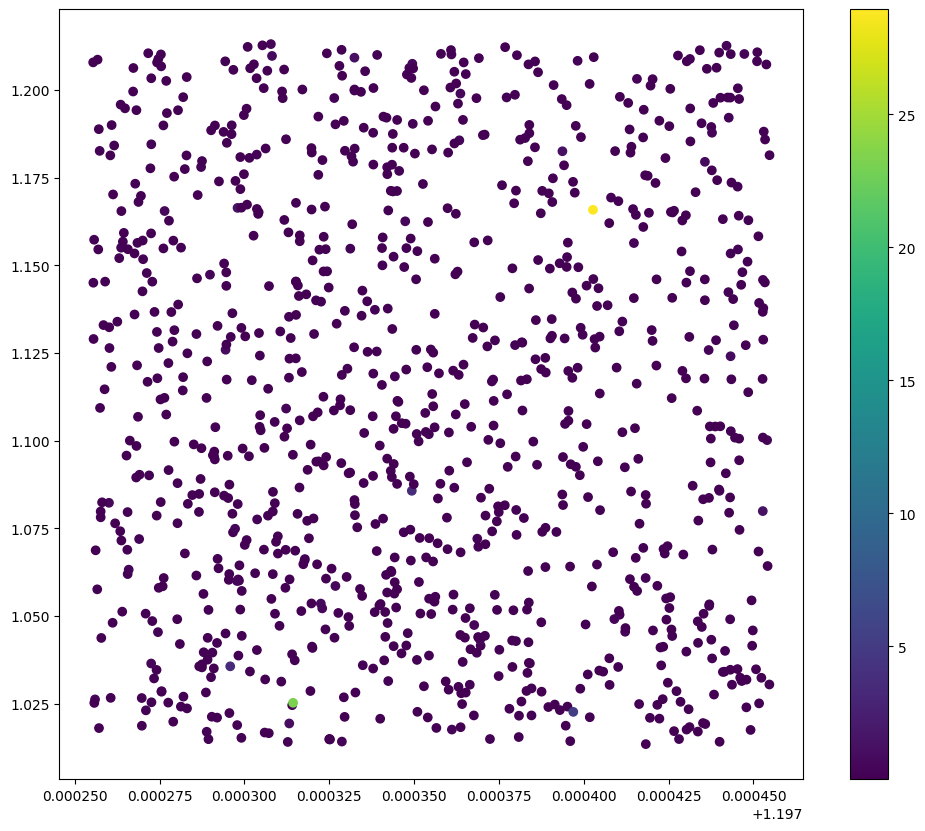

In [126]:
err = abs(np.array(llr_taylor) - np.array(llr_pycbc))/abs(np.array(llr_pycbc))
print(np.min(err), np.median(err))
plt.figure(figsize = (12, 10))
plt.scatter(query_nodes[:, 0], query_nodes[:, 1], c = err)
plt.colorbar()
plt.show()

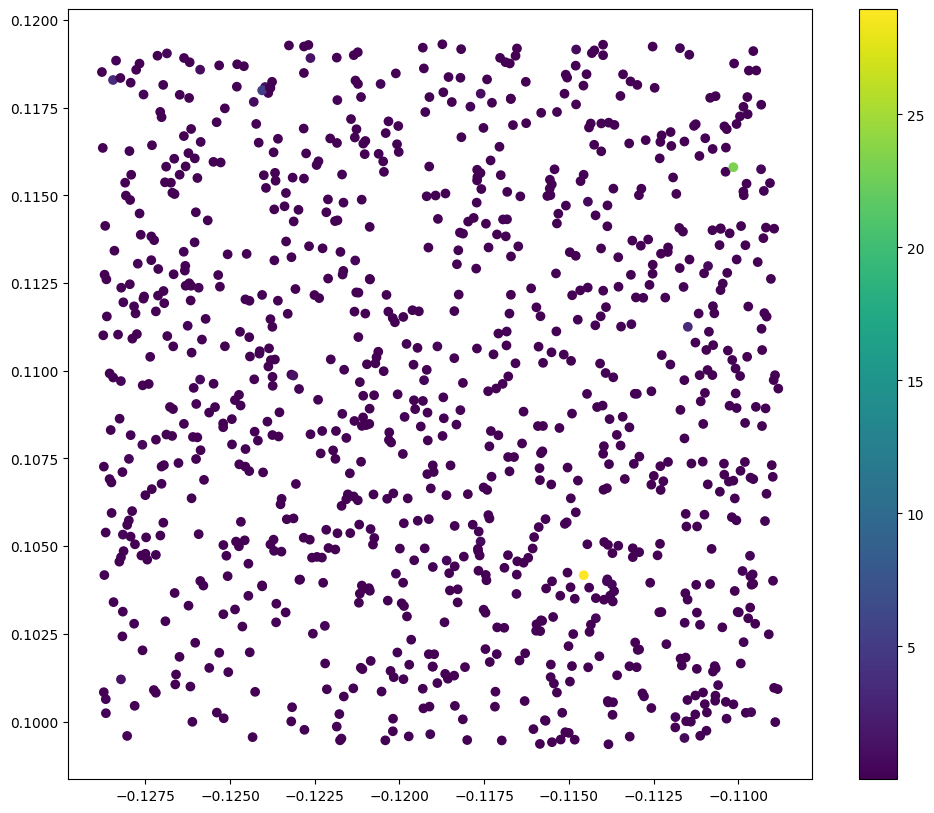

In [127]:
plt.figure(figsize = (12, 10))
plt.scatter(query_nodes[:, 2], query_nodes[:, 3], c = err)
plt.colorbar()
plt.show()

In [ ]:
llr_pycbc_taylor = []
llr_rbf_taylor = []
tc_lis = np.linspace(tc - 0.12, tc + 0.12, 1000)
for i in tqdm(range(len(tc_lis))):
    query_node = np.array([1.19742, 1.15, 0.006, 0.007, 38, tc_lis[i], 3.14, -0.361, 2.54, 0])
    llr_rbf = net_llr(query_node, data['L1'].sample_rate, hp_hp_interpolant_Taylor, C_interpolant_Taylor, basis_vectors_Taylor, det, times_Taylor, 20)
    llr_pycbc = pycbc_log_likelihood_taylor(query_node)
    llr_pycbc_taylor.append(llr_pycbc)
    llr_rbf_taylor.append(llr_rbf)

In [ ]:
llr_pycbc_imr = []
llr_rbf_imr = []
tc_lis = np.linspace(tc - 0.12, tc + 0.12, 1000)
for i in tqdm(range(len(tc_lis))):
    query_node = np.array([1.19742, 1.15, 0.006, 0.007, 38, tc_lis[i], 3.14, -0.361, 2.54, 0])
    llr_rbf = net_llr(query_node, data['L1'].sample_rate, hp_hp_interpolant_IMR, C_interpolant_IMR, basis_vectors_IMR, det, times_IMR, 20)
    llr_pycbc = pycbc_log_likelihood_IMR(query_node)
    llr_pycbc_imr.append(llr_pycbc)
    llr_rbf_imr.append(llr_rbf)

In [ ]:
#plt.plot(tc_lis, np.array(llr_pycbc_imr), ls = '--', label = 'PyCBC IMRPhenomD')
plt.plot(tc_lis, np.array(llr_rbf_imr), label = 'RBF IMRPhenomD')
plt.plot(tc_lis, np.array(llr_pycbc_imr), ls = '--', label = 'PyCBC IMRPhenomD')
plt.plot()
plt.legend()
plt.show()

In [ ]:
plt.plot(tc_lis, np.array(llr_rbf_taylor), label = 'RBF TaylorF2')
plt.plot(tc_lis, np.array(llr_pycbc_taylor), ls = '--', label = 'PyCBC TaylorF2')
plt.legend()
plt.show()

In [ ]:
plt.plot(tc_lis, np.array(llr_rbf_taylor), label = 'RBF TaylorF2')
plt.plot(tc_lis, np.array(llr_rbf_imr), ls = '--', label = 'RBF IMRPhenomD')
plt.legend()
plt.show()

In [ ]:
plt.plot(tc_lis, np.array(llr_pycbc_taylor), label = 'PyCBC TaylorF2')
plt.plot(tc_lis, np.array(llr_pycbc_imr), ls = '--', label = 'PyCBC IMRPhenomD')
plt.legend()
plt.show()

In [81]:
det = {}
for i in ifos:
    det[i] = Detector(i)
llr_pycbc_taylor_far = []
llr_rbf_taylor_far = []
tc_lis = np.linspace(tc - 0.12, tc + 0.12, 1000)
for i in tqdm(range(len(tc_lis))):
    query_node = np.array([1.19740, 1.15, -0.1, 0.12, 38, tc_lis[i], 3.14, -0.361, 2.54, 0])
    llr_rbf_far = net_llr(query_node, data['L1'].sample_rate, hp_hp_interpolant_Taylor, C_interpolant_Taylor, basis_vectors_Taylor, det, times_Taylor, 20)
    llr_pycbc_far = pycbc_log_likelihood_taylor(query_node)
    llr_pycbc_taylor_far.append(llr_pycbc_far) 
    llr_rbf_taylor_far.append(llr_rbf_far)

100%|██████████| 1000/1000 [01:41<00:00,  9.87it/s]


In [67]:
llr_pycbc_imr_far = []
llr_rbf_imr_far = []
tc_lis = np.linspace(tc - 0.12, tc + 0.12, 1000)
for i in tqdm(range(len(tc_lis))):
    query_node = np.array([1.19740, 1.15, -0.08, 0.15, 38, tc_lis[i], 3.14, -0.361, 2.54, 0])
    llr_rbf_far = net_llr(query_node, data['L1'].sample_rate, hp_hp_interpolant_IMR, C_interpolant_IMR, basis_vectors_IMR, det, times_IMR, 20)
    llr_pycbc_far = pycbc_log_likelihood_IMR(query_node)
    llr_pycbc_imr_far.append(llr_pycbc_far) 
    llr_rbf_imr_far.append(llr_rbf_far) 

100%|██████████| 1000/1000 [16:37<00:00,  1.00it/s]


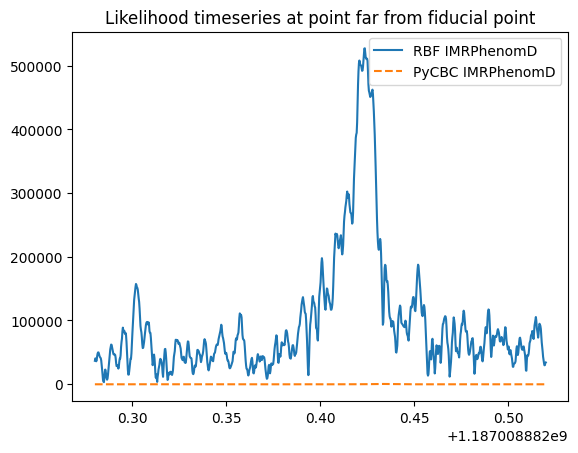

In [68]:
plt.plot(tc_lis, np.array(llr_rbf_imr_far), label = 'RBF IMRPhenomD')
plt.plot(tc_lis, np.array(llr_pycbc_imr_far), ls = '--', label = 'PyCBC IMRPhenomD')
#plt.xlim(tc_lis[np.where(llr_pycbc_imr_far == np.max(llr_pycbc_imr_far))] - 0.01, tc_lis[np.where(llr_pycbc_imr_far == np.max(llr_pycbc_imr_far))] + 0.01)
plt.legend()
plt.title('Likelihood timeseries at point far from fiducial point')
plt.show()

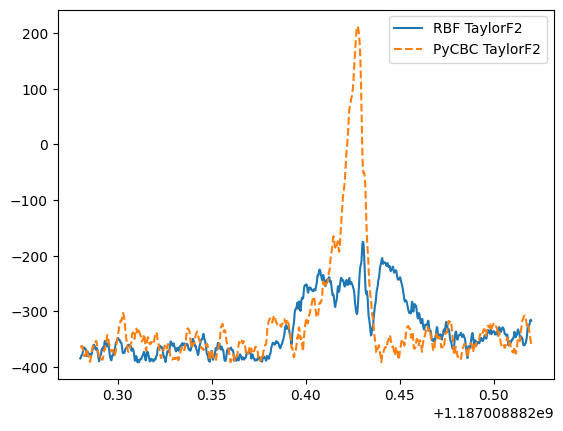

In [82]:
plt.plot(tc_lis, np.array(llr_rbf_taylor_far), label = 'RBF TaylorF2')
plt.plot(tc_lis, np.array(llr_pycbc_taylor_far), ls = '--', label = 'PyCBC TaylorF2')
#plt.xlim(tc_lis[np.where(llr_pycbc_taylor_far == np.max(llr_pycbc_taylor_far))] - 0.01, tc_lis[np.where(llr_pycbc_taylor_far == np.max(llr_pycbc_taylor_far))] + 0.01)
plt.legend()
plt.show()